# Домашнее задание №6. Кластеризация и SVM

## Ф.И.О: Винарский Александр Анатольевич

В этом домашнем задании вам предстоит собственноручно написать методы кластеризации и метод опорных векторов. В качестве вспомогательных материалов мы прилагаем ссылки на статьи и ресурсы, которые содержат подробную информацию о представленных алгоритмах.

#### Полезные ссылки:

1. [Описание](https://scikit-learn.org/stable/modules/clustering.html#k-means) K-means от scikit-learn
2. Статья по алгоритму [K-means++](https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf)
3. Статья по алгоритму [DBSCAN](https://cdn.aaai.org/KDD/1996/KDD96-037.pdf)
4. Статья по алгоритму [SVM](https://link.springer.com/content/pdf/10.1007/bf00994018.pdf)
5. [Описание](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html) параметров Radial Basis Function (RBF) от scikit-learn

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.datasets import load_iris, make_classification, make_moons
from cvxopt import matrix, solvers

### __1__. Реализация алгортима K-means (6 points)

----------------------------

#### __1.1__. Реализуйте алгоритм K-means без использования библиотек с реализацией данного метода (по типу библиотеки sklearn) (3 points)

In [2]:
def k_means(X, k, max_iters=3, tol=1e-4):
    """ Реализуйте алгоритм K-Means """
    np.random.seed(42)

    X = np.asarray(X)
    n_samples, n_features = X.shape

    def init_centroids_kmeanspp(X, k):
        n_samples= X.shape[0]
        indices= []
        first_idx= np.random.randint(n_samples)
        indices.append(first_idx)
        centroids= [X[first_idx]]

        for i in range(1, k):
            cent_array= np.array(centroids)
            dist_sq= np.square(X[:, None, :]-cent_array[None, :, :]).sum(axis=2).min(axis=1)
            total= dist_sq.sum()
            if total== 0:
                next_idx= np.random.randint(n_samples)
            else:
                probs= dist_sq / total
                r= np.random.rand()
                cumulative= np.cumsum(probs)
                next_idx= np.searchsorted(cumulative, r)
            indices.append(next_idx)
            centroids.append(X[next_idx])
        return np.array(centroids)



    def run_single_kmeans(X, k, max_iters, tol):
        centroids= init_centroids_kmeanspp(X, k)
        n_samples= X.shape[0]

        for i in range(max_iters):
            dists= np.square(X[:, None, :] - centroids[None, :, :]).sum(axis=2)
            labels= np.argmin(dists, axis=1)
            new_centroids= np.zeros_like(centroids)

            for j in range(k):
                mask= (labels== j)
                if np.any(mask):
                    new_centroids[j] = X[mask].mean(axis=0)
                else:
                    new_centroids[j] = X[np.random.randint(n_samples)]
            shift= np.linalg.norm(new_centroids - centroids)
            centroids= new_centroids
            if shift< tol:
                break
        inertia = np.square(X - centroids[labels]).sum()
        return labels, centroids, inertia




    n_init= 10
    best_labels= None
    best_centroids= None
    best_inertia= None

    for i in range(n_init):
        labels, centroids, inertia= run_single_kmeans(X, k, max_iters, tol)
        if best_inertia is None or inertia< best_inertia:
            best_inertia= inertia
            best_labels= labels
            best_centroids= centroids

    return best_labels, best_centroids





# Automatic Checker
def check_k_means():
    iris = load_iris()
    X = iris.data
    y_true = iris.target

    labels_custom, centroids_custom = k_means(X, k=3)
    kmeans_sklearn = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X)
    labels_sklearn = kmeans_sklearn.labels_

    score_custom = adjusted_rand_score(y_true, labels_custom)
    score_sklearn = adjusted_rand_score(y_true, labels_sklearn)
    print(score_custom)
    print(score_sklearn)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis', marker='o')
    plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], s=300, c='red', marker='X')
    plt.title('K-Means Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    assert labels_custom is not None, "Function should return labels."
    assert len(labels_custom) == len(X), "Should return labels for all points."
    assert score_custom > 0.7, "Clustering should achieve a higher score."
    print(f"Task 1.1 Passed! Adjusted Rand Score: {score_custom:.2f}")

0.7302382722834697
0.7302382722834697
Task 1.1 Passed! Adjusted Rand Score: 0.73


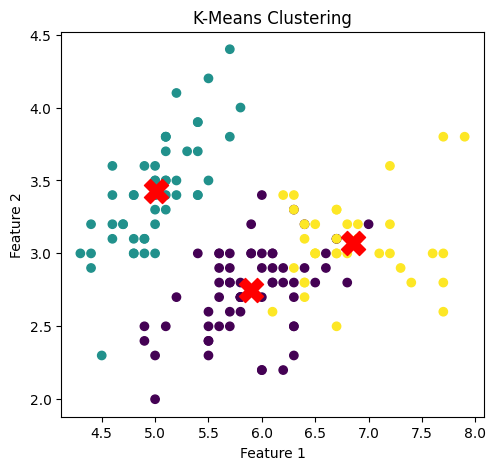

In [3]:
check_k_means()

#### __1.2__. Реализуйте алгоритм K-means++ без использования библиотек с реализацией данного метода (3 points)

In [4]:
def initialize_plus_plus(X, k):
    """ Инициализируйте центры кластеров """
    np.random.seed(42)
    X= np.asarray(X)
    n_samples, n_features= X.shape
    centroids= np.empty((k, n_features), dtype=X.dtype)
    first_idx= np.random.randint(n_samples)
    centroids[0]= X[first_idx]
    closest_dist_sq= np.square(X-centroids[0]).sum(axis=1)

    for i in range(1, k):
        probs = closest_dist_sq / closest_dist_sq.sum()
        next_idx = np.random.choice(n_samples, p=probs)
        centroids[i] = X[next_idx]
        dist_sq = np.square(X - centroids[i]).sum(axis=1)
        closest_dist_sq = np.minimum(closest_dist_sq, dist_sq)

    return centroids




def k_means_plus_plus(X, k, max_iters=100, tol=1e-4):
    """ реализуйте алгоритм K-means++ """
    X= np.asarray(X)
    n_samples, n_features= X.shape
    centroids= initialize_plus_plus(X, k)

    for i in range(max_iters):
        dists= np.square(X[:, None, :]-centroids[None, :, :]).sum(axis=2)
        labels= np.argmin(dists, axis=1)
        new_centroids= np.empty_like(centroids)

        for j in range(k):
            mask= labels== j
            if np.any(mask):
                new_centroids[j]= X[mask].mean(axis=0)
            else:
                new_centroids[j]= X[np.random.randint(n_samples)]
        shift= np.linalg.norm(new_centroids-centroids)
        centroids= new_centroids
        if shift< tol:
            break

    return labels, centroids



# Automatic Checker
def check_k_means_plus_plus():
    iris = load_iris()
    X = iris.data
    y_true = iris.target

    labels_custom, centroids_custom = k_means_plus_plus(X, k=3)
    kmeans_sklearn = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10).fit(X)
    labels_sklearn = kmeans_sklearn.labels_

    score_custom = adjusted_rand_score(y_true, labels_custom)
    score_sklearn = adjusted_rand_score(y_true, labels_sklearn)
    print(score_custom)
    print(score_sklearn)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis', marker='o')
    plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], s=300, c='red', marker='X')
    plt.title('K-Means++ Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    assert labels_custom is not None, "Function should return labels."
    assert len(labels_custom) == len(X), "Should return labels for all points."
    assert score_custom > 0.7, "Clustering should achieve a higher score."
    print(f"Task 1.2 Passed! Adjusted Rand Score: {score_custom:.2f}")


0.7163421126838476
0.7302382722834697
Task 1.2 Passed! Adjusted Rand Score: 0.72


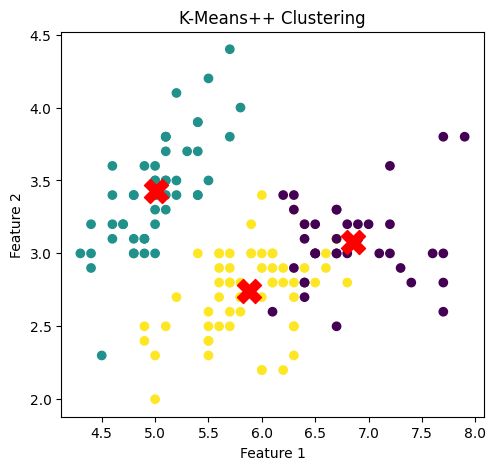

In [5]:
check_k_means_plus_plus()

### __2__. Оценка алгоритма DBSCAN (4 points)

Предположим, что вы анализируете движение такси в городе, чтобы определить популярные зоны посадки. У вас есть набор данных, представляющий места посадки такси.

```
data_points = [
    (1.2, 3.1), (2.5, 3.3), (1.8, 2.9), (8.2, 7.5),
    (8.1, 7.7), (25.3, 80.2), (2.0, 3.0), (3.0, 3.5),
    (1.1, 1.2), (90.0, 91.2), (1.5, 3.2), (8.0, 7.6),
    (2.2, 3.1), (7.9, 7.8), (1.3, 3.0)
]
```

Каждая точка представляет место посадки в такси с координатами (x, y) км от центра города.

С помощью алгортима DBSCAN сгруппируйте эти поездки на такси, чтобы определить зоны с высокой плотностью посадки. Укажите, какие из точек core, а какие являются выбросами.

Указание: выберите максимальное расстояние между точками равным __1.5__ и минимальное число точек в группе равным __3__.

Для решения этой задачи не используйте библиотеки с реализацией DBSCAN.

In [7]:
# Your code here
data_points = [
    (1.2, 3.1), (2.5, 3.3), (1.8, 2.9), (8.2, 7.5),
    (8.1, 7.7), (25.3, 80.2), (2.0, 3.0), (3.0, 3.5),
    (1.1, 1.2), (90.0, 91.2), (1.5, 3.2), (8.0, 7.6),
    (2.2, 3.1), (7.9, 7.8), (1.3, 3.0)
]

eps= 1.5
min_pts= 3
points= np.array(data_points)

def dbscan(points, eps, min_pts):
    n= len(points)
    labels= np.zeros(n, dtype=int)
    cluster_id= 0

    def region_query(idx):
        diff= points - points[idx]
        dist_sq= (diff ** 2).sum(axis=1)
        return np.where(dist_sq <= eps ** 2)[0]

    for i in range(n):
        if labels[i] != 0:
            continue
        neighbors = region_query(i)
        if neighbors.size < min_pts:
            labels[i]= -1
        else:
            cluster_id+= 1
            labels[i]= cluster_id
            seeds= list(neighbors)
            seeds.remove(i)
            while seeds:
                j= seeds.pop()
                if (labels[j]== -1):
                    labels[j]= cluster_id
                if (labels[j]!= 0):
                    continue
                labels[j]= cluster_id
                neighbors_j= region_query(j)
                if neighbors_j.size>= min_pts:
                    for q in neighbors_j:
                        if labels[q] in (0, -1):
                            seeds.append(q)
    return labels

labels = dbscan(points, eps, min_pts)

def neighbors_indices(idx):
    diff= points - points[idx]
    dist_sq= (diff**2).sum(axis=1)
    return np.where(dist_sq<= eps ** 2)[0]

core_points = []
noise_points = []
for i, lab in enumerate(labels):
    if lab == -1:
        noise_points.append(data_points[i])
    else:
        if len(neighbors_indices(i)) >= min_pts:
            core_points.append(data_points[i])

print("Cluster labels:", labels.tolist())
print("Core points:", core_points)
print("Noise points:", noise_points)

Cluster labels: [1, 1, 1, 2, 2, -1, 1, 1, -1, -1, 1, 2, 1, 2, 1]
Core points: [(1.2, 3.1), (2.5, 3.3), (1.8, 2.9), (8.2, 7.5), (8.1, 7.7), (2.0, 3.0), (3.0, 3.5), (1.5, 3.2), (8.0, 7.6), (2.2, 3.1), (7.9, 7.8), (1.3, 3.0)]
Noise points: [(25.3, 80.2), (1.1, 1.2), (90.0, 91.2)]


### __3__. (Доп.) Оценка алгоритма SVM (5 points)

Рассмотрим набор данных в 2D-пространстве, где первые два значения - это координаты точек, а третье значение - метка класса:

```
data_points = [
    (-4, 2, 1), (-1, -1, -1), (0, -2, -1), (1, -2, -1),
    (2, 3, 1), (3, 3, 1), (4, 4, 1), (-4, -3, -1), (-5, -2, -1),
    (5, 2, 1), (6, 1, 1), (-6, -1, -1), (-7, -3, -1), (7, 3, 1),
    (8, 4, 1), (-8, -5, -1), (9, 5, 1), (-9, -4, -1), (10, 6, 1),
]
```

1. Определите уравнение прямой, которая наилучшим образом разделяет два класса
2. Определите величину зазора (margin) и вектор, ортогональный разделяющей границе
3. Определите, какие точки являются опорными векторами

Указание: в данной задаче необходимо преобразовать двойственную задачу SVM к стандартному виду квадратичной задачи и использовать солвер (см. импорты и [документацию cvxopt](https://cvxopt.org/examples/tutorial/qp.html)), чтобы восстановить разделяющую гиперплоскость и опорные вектора.

In [14]:
# Your code here
from cvxopt import matrix, solvers

data_points = [
    (-4, 2, 1), (-1, -1, -1), (0, -2, -1), (1, -2, -1),
    (2, 3, 1), (3, 3, 1), (4, 4, 1), (-4, -3, -1), (-5, -2, -1),
    (5, 2, 1), (6, 1, 1), (-6, -1, -1), (-7, -3, -1), (7, 3, 1),
    (8, 4, 1), (-8, -5, -1), (9, 5, 1), (-9, -4, -1), (10, 6, 1),
]

X= np.array([[x, y] for x, y, c in data_points], dtype="float64")
y= np.array([c for x, y, c in data_points], dtype="float64")
n= len(y)
K= X@X.T
Q= np.outer(y, y)*K
Q= 0.5*(Q+Q.T)
P= matrix(Q)
q= matrix(-np.ones(n))
G= matrix(-np.eye(n))
h= matrix(np.zeros(n))
A= matrix(y, (1, n), "d")
b= matrix(0.0)
solvers.options["show_progress"] = False
solution= solvers.qp(P, q, G, h, A, b)
alphas= np.array(solution["x"]).reshape(-1)

w= ((alphas*y)[:, None] * X).sum(axis=0)
norm_w= np.linalg.norm(w)
margin= 1.0 / norm_w
sv_mask= alphas > 1e-5
sv_indices= np.where(sv_mask)[0]
b_vals= [y[i]-X[i] @ w for i in sv_indices]
b= float(np.mean(b_vals))

print("w:", w)
print("b:", b)
print("margin:", margin)
print("decision boundary: %.4f * x1 + %.4f * x2 + %.4f = 0" % (w[0], w[1], b))
print("support vector indices:", sv_indices.tolist())
print("support vectors:", [data_points[i] for i in sv_indices])


w: [0.07407409 0.74074079]
b: -0.18518522646341254
margin: 1.343300109380807
decision boundary: 0.0741 * x1 + 0.7407 * x2 + -0.1852 = 0
support vector indices: [0, 1, 10]
support vectors: [(-4, 2, 1), (-1, -1, -1), (6, 1, 1)]


### __4__. Реализация алгоритма SVM (10 points)

----------------------------

#### __4.1__. Реализуйте алгоритм Linear SVM без использования библиотек с реализацией данного метода (5 points)

In [20]:
def linear_svm(X, y, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
    """ Реализуйте Linear SVM """
    np.random.seed(42)
    X= np.asarray(X, dtype=float)
    y= np.asarray(y, dtype=float)
    n_samples, n_features= X.shape
    weights= np.zeros(n_features)
    bias= 0.0

    for i in range(n_iters):
        margins= y*(X@weights- bias)
        mask= margins< 1
        if np.any(mask):
            grad_w= lambda_param*weights-(X[mask]*y[mask][:, None]).sum(axis=0)/n_samples
            grad_b= y[mask].sum()/n_samples
        else:
            grad_w= lambda_param*weights
            grad_b= 0.0
        weights-= learning_rate*grad_w
        bias-= learning_rate*grad_b

    return weights, bias

def predict_svm(X, weights, bias):
    return np.sign(np.dot(X, weights) - bias)

# Automatic Checker
def check_linear_svm():
    X, y = make_classification(n_samples=1000, n_features=4, n_informative=2, n_redundant=0, random_state=42)
    y = np.where(y == 0, -1, 1)

    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    weights, bias = linear_svm(X, y)
    y_pred = predict_svm(X, weights, bias)

    svm_sklearn = SVC(kernel='linear', random_state=42)
    svm_sklearn.fit(X, y)
    y_pred_sklearn = svm_sklearn.predict(X)

    accuracy = accuracy_score(y, y_pred)
    accuracy_sklearn = accuracy_score(y, y_pred_sklearn)

    assert accuracy > 0.85, "Accuracy should be higher"
    print(f"Task 4.1 Passed! Accuracy: {accuracy:.2f}")

In [21]:
check_linear_svm()

Task 4.1 Passed! Accuracy: 0.87


#### __4.2__. Реализуйте Kernel SVM с использованием RBF ядра без использования библиотек с реализацией данного метода (5 points)

In [23]:
def rbf_kernel(X, Y=None, gamma=0.1):
    if Y is None:
        Y = X
    """ Определите RBF kernel """
    # Your code here
    X= np.asarray(X, dtype=float)
    Y= np.asarray(Y, dtype=float)
    X_norm= np.sum(X**2, axis=1)[:, None]
    Y_norm= np.sum(Y**2, axis=1)[None, :]
    return np.exp(-gamma*(X_norm+Y_norm-2*np.dot(X, Y.T)))

def kernel_svm(X, y, gamma=0.1, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
    """ Реализуйте Kernel SVM """
    np.random.seed(42)
    # Your code here
    X= np.asarray(X, dtype=float)
    y= np.asarray(y, dtype=float)
    n_samples= X.shape[0]
    K= rbf_kernel(X, gamma=gamma)
    alpha= np.zeros(n_samples)
    C= 1.0/lambda_param
    for i in range(n_iters):
        Ky= K @ (alpha*y)
        grad= 1.0-Ky*y
        alpha+= learning_rate*grad
        alpha= np.clip(alpha, 0.0, C)
    return alpha
    pass

def predict_kernel_svm(X, X_train, y_train, alpha, gamma=0.1):
    K = rbf_kernel(X, X_train, gamma)
    return np.sign(np.dot(K, alpha * y_train))

# Automatic Checker
def check_kernel_svm():
    X, y = make_moons(n_samples=50, noise=0.01, random_state=42)
    y = np.where(y == 0, -1, 1)

    alpha = kernel_svm(X, y)
    y_pred = predict_kernel_svm(X, X, y, alpha)

    svm_sklearn = SVC(kernel='rbf', gamma=0.1, random_state=42)
    svm_sklearn.fit(X, y)
    y_pred_sklearn = svm_sklearn.predict(X)

    accuracy = accuracy_score(y, y_pred)
    accuracy_sklearn = accuracy_score(y, y_pred_sklearn)

    print(accuracy_sklearn)

    assert accuracy > 0.8, "Accuracy should be higher"
    print(f"Task 4.2 Passed! Accuracy: {accuracy:.2f}")

In [24]:
check_kernel_svm()

0.84
Task 4.2 Passed! Accuracy: 0.84
